# PROJEKT MODELU REGRESYJNEGO PRZEWIDYWANIA CEN MIESZKAŃ NA PODSTAWIE #

# ALGORYTMU LGBM #

  ## KWIECIEŃ 2025 ##

In [1]:
import pandas as pd
import mlflow
from pycaret.datasets import get_data
from pycaret.regression import setup, pull, compare_models, plot_model, load_model
import pymysql
from sqlalchemy import create_engine
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

In [2]:
# tą komórkę uruchom jeżeli bazie bierzesz np. z DBeaver
# username = 'root'
# password = '1234'
# host = '127.0.0.1'
# port = 3306  
# database = 'projekt1'
# engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# df = pd.read_sql("SELECT * FROM saleflats", con=engine)

# engine.dispose()

In [3]:
MLFLOW_EXPERIMENT_NAME = 'Investoro_Ceny'
MLFLOW_TAGS = {'data': 'Investoro_ceny', 'library': 'pycaret'}

mlflow.set_tracking_uri("http://localhost:5000")

In [4]:
# tę komórkę uruchom jeśli czerpiesz dane z pliku .csv
df = pd.read_csv('sale_2024_0.csv', sep=',')

In [5]:
df

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133882,4418401,NaN,2,Mieszkanie na sprzedaż - 59 m² - 3 pokoje Grod...,Poznaj naszą inwestycję NA WSPÓLNEJ zlokalizow...,59.99,NaN,NaN,NaN,NaN,...,NaN,"Mazowieckie, Grodziski, Grodzisk Mazowiecki, W...",14.0,5.0,4.0,5.0,2594.0,NaN,24885.0,Ogpi4Jwj8KWDyT0rM_vFYftiMRU9ErLfA6XOKdBw9jY=
1133883,4418402,NaN,2,Mieszkanie na sprzedaż - 41 m² - 2 pokoje Grod...,Poznaj naszą inwestycję NA WSPÓLNEJ zlokalizow...,41.23,NaN,NaN,NaN,NaN,...,NaN,"Mazowieckie, Grodziski, Grodzisk Mazowiecki, W...",14.0,5.0,4.0,5.0,2594.0,NaN,24885.0,Ogpi4Jwj8KWDyT0rM_vFYa7D8z7yjun2jGP_aZIReN8=
1133884,4418404,NaN,2,Mieszkanie na sprzedaż - 49 m² - 3 pokoje Grod...,Poznaj naszą inwestycję NA WSPÓLNEJ zlokalizow...,49.09,NaN,NaN,NaN,NaN,...,NaN,"Mazowieckie, Grodziski, Grodzisk Mazowiecki, W...",14.0,5.0,4.0,5.0,2594.0,NaN,24885.0,Ogpi4Jwj8KWDyT0rM_vFYf9eM73_U8S05NBjfLiez6E=
1133885,4418405,NaN,2,Mieszkanie na sprzedaż - 49 m² - 3 pokoje Grod...,Poznaj naszą inwestycję NA WSPÓLNEJ zlokalizow...,49.48,NaN,NaN,NaN,NaN,...,NaN,"Mazowieckie, Grodziski, Grodzisk Mazowiecki, W...",14.0,5.0,4.0,5.0,2594.0,NaN,24885.0,Ogpi4Jwj8KWDyT0rM_vFYRXVZdKE7iJxxFPu0Bq0ikc=


In [6]:
df.head(10)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==
5,159,NaN,3,"Mieszkanie, 87 m², Białystok","Przestronne, jasne mieszkanie na zamkniętym os...",87.00,779000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,SEPz6jrRB1vuWWYOn99h7g==
6,165,NaN,3,Przytulne mieszkanie blisko centrum!,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.10,359000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,16041.0,Gt5-LUpJNg-wBgBd8-hxGQ==
7,173,NaN,3,"**Jasne, 2 Pokojowe Mieszkanie, Widok Na Miasto**","Mieszkanie o powierzchni 35,7 m2 Ul. Jarzębino...",35.70,380000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok",20.0,61.0,1.0,1.0,922410.0,NaN,7290.0,a5iP5JQyibefTTLgBRU8oA==
8,179,NaN,3,*Bezpośrednio*PIĘKNY APARTAMENT w Centrum Lipo...,***REZERWACJA ***WYJĄTKOWA PROPOZYCJA DLA WYMA...,39.40,559000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,C_F7Bxl4hKQ2a2votBqs-g==
9,189,NaN,4,2-pokojowe mieszkanie na sprzedaż,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.20,354000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Piasta",20.0,61.0,1.0,1.0,922410.0,NaN,16041.0,XylelQthYlIn_7k8orxBfQ==


In [7]:
df.sample(10)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
1068890,4300145,NaN,3,Ruczaj 2 pokojowe ul. Piltza,Na sprzedaż oferuję dwupokojowe mieszkanie o p...,45.66,725994.0,794760.0,961666.67,NaN,...,NaN,"Małopolskie, Kraków, Kraków-podgórze, Kobierzy...",12.0,61.0,4.0,9.0,951066.0,NaN,33381.0,98wID5JhDHcGQKizQYpUL2OX94vBVnrWznFwIq8TfgE=
190803,1389176,NaN,18,2-pokojowe mieszkanie do wykończenia w supercenie,Opiekun oferty Magdalena Masłowska tel. 602101...,37.75,522600.0,NaN,NaN,NaN,...,NaN,"Dolnośląskie, Wrocław, Wrocław-krzyki, Ul. Gazowa",2.0,64.0,3.0,9.0,986544.0,NaN,5403.0,wrRGOed4jrzHIdHLWxbSNGjzzGldvCsejqBZGAbYChc=
1034843,4231734,NaN,38,Mieszkanie 2 pokojowe,Oferta aktualna - możliwość umówienia bezpiecz...,41.00,585724.0,NaN,NaN,NaN,...,NaN,"Kujawsko-pomorskie, Bydgoszcz, Centrum",4.0,61.0,1.0,1.0,1067611.0,NaN,NaN,Ez0fqOp00V4QUZ8AvXPFfFS1vaJF4VCGA1NSnEfSywA=
1123561,4403078,NaN,19,Mieszkanie w kamienicy,Oferta sprzedaży wyjątkowego mieszkania w kami...,96.10,620000.0,NaN,NaN,NaN,...,NaN,"Dolnośląskie, Jaworski, Jawor",2.0,5.0,1.0,1.0,954120.0,NaN,NaN,qVd4JAXOCEokaiXQkKrMB6XA85RWXE2DCF5KBh3a4Js=
907355,3913459,NaN,3,Miękinia / bez prowizji,| Wszystkie mieszkania w budynkach wielorodzin...,58.00,482000.0,NaN,NaN,NaN,...,NaN,"Dolnośląskie, Średzki, Miękinia",2.0,18.0,3.0,4.0,NaN,NaN,NaN,mVvkNxyNTrY4LV8cqYwlvwAQzbPZDnsbuGvFGXpz1mg=
1047467,4256851,NaN,4,3-pokojowe mieszkanie na sprzedaż,Sprzedam rozkładowe mieszkanie 3-pokojowe w ce...,48.00,385000.0,355000.0,448797.90,NaN,...,NaN,"Łódzkie, Łowicki, Łowicz",10.0,5.0,1.0,1.0,977031.0,NaN,NaN,qNvpnwql2JMbwqzViT4s-NPMqpHF6X1wDc4eEYzDo2s=
153345,1085583,NaN,3,GARAŻ za 0PLN oferta na DNI otwarte 26+27.4_tr...,DRZWI OTWARTE 25-27.04 w g. 9-18 - zarezerwuj ...,39.27,478160.0,NaN,NaN,NaN,...,NaN,"Wielkopolskie, Poznań, Poznań-nowe Miasto, Rataje",30.0,64.0,4.0,9.0,970081.0,NaN,NaN,bP45mmWcL6tje9UN0PY0Xsc0fBXCdCR2219soBArV2g=
936657,3991028,NaN,3,2 pokoje + KOmórka + PARKING_zobacz na żywo,Zakup bezpośrednio od dewelopera – brak prowiz...,37.00,415000.0,499000.0,1130753.33,396100.0,...,NaN,"Pomorskie, Gdańsk",22.0,61.0,NaN,NaN,NaN,NaN,NaN,RrAP9O0O2Jfa6BD9SUlYHo_bCM8lJ876moazm9h2OAo=
780468,3576637,NaN,18,"Mieszkanie 3-pokojowe o pow. 46m2, parter, osi...","Na SPRZEDAŻ 3 - POKOJOWE MIESZKANIE, pow. 46 m...",45.94,349000.0,NaN,NaN,NaN,...,NaN,"Wielkopolskie, Pilski, Piła",30.0,19.0,1.0,1.0,966530.0,NaN,NaN,kX_ZYmp6Ui7g0uvwd7awRVsBl2chVeLJOWFXdp_Irxg=
216331,1572695,NaN,3,M-4 centrum*po generalnym remoncie* klimatyzacja,*Oferta skierowana dla klientów szukających mi...,56.00,355000.0,NaN,NaN,NaN,...,NaN,"Śląskie, Żory",24.0,79.0,1.0,1.0,945746.0,NaN,NaN,ON3hWexmvVURa0ExjPgKZZ3inEDRqPi2MpqZO5i4jCY=


In [8]:
df.info

<bound method DataFrame.info of           SaleId  OriginalId  PortalId  \
0             88         NaN        14   
1             99         NaN        19   
2            115         NaN         3   
3            140         NaN        14   
4            145         NaN         3   
...          ...         ...       ...   
1133882  4418401         NaN         2   
1133883  4418402         NaN         2   
1133884  4418404         NaN         2   
1133885  4418405         NaN         2   
1133886  4418406         NaN         2   

                                                     Title  \
0                      Mieszkanie trzypokojowe na sprzedaż   
1        Sprzedam mieszkanie na parterze 64.8m2 Białyst...   
2            Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki   
3                      Mieszkanie trzypokojowe na sprzedaż   
4                       3 Pokoje- 48M2-Osiedle Dziesięciny   
...                                                    ...   
1133882  Mieszkanie na sprzed

In [9]:
df[df.duplicated()]

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId


In [10]:
df.nunique()

SaleId                       1133887
OriginalId                         0
PortalId                          35
Title                         635825
Description                   982079
Area                           14360
Price                         131353
OfferPrice                     23232
RealPriceAfterRenovation       29481
OriginalPrice                  17584
PricePerSquareMeter           306308
NumberOfRooms                     90
BuiltYear                        281
Type                               2
BuildingType                       4
BuildingCondition                  4
OfferFrom                          2
Floor                             62
Floors                            77
TypeOfMarket                       2
OwnerType                         96
DateAddedToDatabase          1082247
DateAdded                    1066927
DateLastModification          242626
DateLastRaises                292764
NewestDate                   1070077
AvailableFrom                      0
L

In [11]:
correlation_matrix = df[['Area', 'Price', 'BuiltYear', 'Floor', 'Floors', 'CommunityScore', 'CountyNumber', 'CommunityNumber',
                               'RegionNumber','KindNumber']].corr()

Text(0.5, 1.0, 'Correlation Matrix of Price')

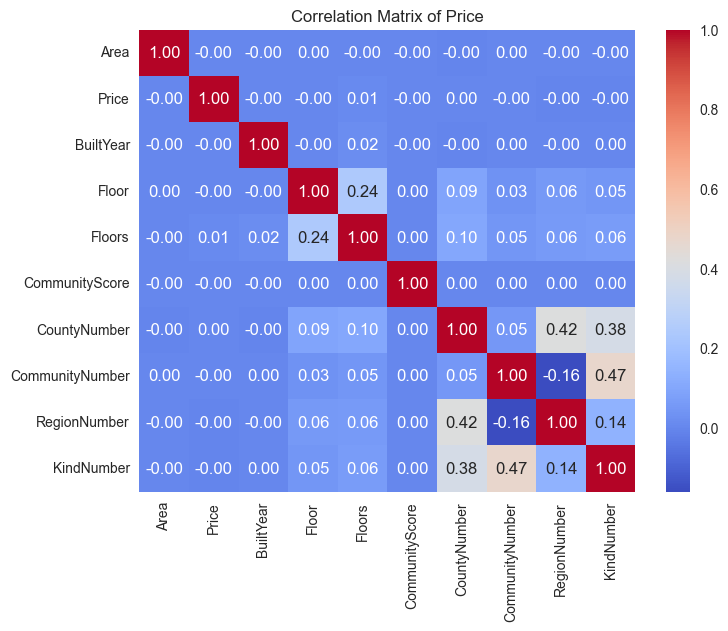

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Price')

In [13]:
df.isnull()

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,False,True,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,True,True,False
1,False,True,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,True,True,False
2,False,True,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,True,True,False
3,False,True,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,True,False,False
4,False,True,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133882,False,True,False,False,False,False,True,True,True,True,...,True,False,False,False,False,False,False,True,False,False
1133883,False,True,False,False,False,False,True,True,True,True,...,True,False,False,False,False,False,False,True,False,False
1133884,False,True,False,False,False,False,True,True,True,True,...,True,False,False,False,False,False,False,True,False,False
1133885,False,True,False,False,False,False,True,True,True,True,...,True,False,False,False,False,False,False,True,False,False


In [14]:
df.isnull().sum()

SaleId                             0
OriginalId                   1133887
PortalId                           0
Title                              0
Description                     8664
Area                            3393
Price                          53424
OfferPrice                   1050699
RealPriceAfterRenovation     1050699
OriginalPrice                1023184
PricePerSquareMeter            57801
NumberOfRooms                  14847
BuiltYear                     382478
Type                               0
BuildingType                  206452
BuildingCondition            1055766
OfferFrom                       5031
Floor                          58979
Floors                        505193
TypeOfMarket                   33527
OwnerType                     545555
DateAddedToDatabase                0
DateAdded                          0
DateLastModification          886552
DateLastRaises                835087
NewestDate                         0
AvailableFrom                1133887
L

In [15]:
df_beznull_price = df.dropna(subset=['Area'])

In [16]:
df_beznull_price.isnull().sum()

SaleId                             0
OriginalId                   1130494
PortalId                           0
Title                              0
Description                     7348
Area                               0
Price                          53291
OfferPrice                   1047306
RealPriceAfterRenovation     1047306
OriginalPrice                1019890
PricePerSquareMeter            54408
NumberOfRooms                  12124
BuiltYear                     379203
Type                               0
BuildingType                  204053
BuildingCondition            1052403
OfferFrom                       4742
Floor                          56314
Floors                        501959
TypeOfMarket                   32011
OwnerType                     542422
DateAddedToDatabase                0
DateAdded                          0
DateLastModification          883586
DateLastRaises                832330
NewestDate                         0
AvailableFrom                1130494
L

In [17]:
# df_beznull_price2 = df_beznull_price.sort_values('Area').interpolate()

In [18]:
df_beznull_price.head(20)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==
5,159,NaN,3,"Mieszkanie, 87 m², Białystok","Przestronne, jasne mieszkanie na zamkniętym os...",87.00,779000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,SEPz6jrRB1vuWWYOn99h7g==
6,165,NaN,3,Przytulne mieszkanie blisko centrum!,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.10,359000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,16041.0,Gt5-LUpJNg-wBgBd8-hxGQ==
7,173,NaN,3,"**Jasne, 2 Pokojowe Mieszkanie, Widok Na Miasto**","Mieszkanie o powierzchni 35,7 m2 Ul. Jarzębino...",35.70,380000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok",20.0,61.0,1.0,1.0,922410.0,NaN,7290.0,a5iP5JQyibefTTLgBRU8oA==
8,179,NaN,3,*Bezpośrednio*PIĘKNY APARTAMENT w Centrum Lipo...,***REZERWACJA ***WYJĄTKOWA PROPOZYCJA DLA WYMA...,39.40,559000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,C_F7Bxl4hKQ2a2votBqs-g==
9,189,NaN,4,2-pokojowe mieszkanie na sprzedaż,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.20,354000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Piasta",20.0,61.0,1.0,1.0,922410.0,NaN,16041.0,XylelQthYlIn_7k8orxBfQ==


In [19]:
Q1 = df_beznull_price["Price"].quantile(0.25)
Q3 = df_beznull_price["Price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price_p = df_beznull_price[~((df_beznull_price["Price"] < lower_bound) | (df_beznull_price["Price"] > upper_bound))]

In [20]:
Q1 = df_price_p["PricePerSquareMeter"].quantile(0.25)
Q3 = df_price_p["PricePerSquareMeter"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price_a = df_price_p[~((df_price_p["PricePerSquareMeter"] < lower_bound) | (df_price_p["PricePerSquareMeter"] > upper_bound))]


In [21]:
Q1 = df_price_a["Area"].quantile(0.25)
Q3 = df_price_a["Area"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price1 = df_price_a[~((df_price_a["Area"] < lower_bound) | (df_price_a["Area"] > upper_bound))]

In [22]:
df_price1['BuiltYear'] = pd.to_datetime(df_price1['BuiltYear'], format='%Y', errors='coerce')

In [23]:
df_price1.head(20)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==
5,159,NaN,3,"Mieszkanie, 87 m², Białystok","Przestronne, jasne mieszkanie na zamkniętym os...",87.00,779000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,SEPz6jrRB1vuWWYOn99h7g==
6,165,NaN,3,Przytulne mieszkanie blisko centrum!,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.10,359000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,16041.0,Gt5-LUpJNg-wBgBd8-hxGQ==
7,173,NaN,3,"**Jasne, 2 Pokojowe Mieszkanie, Widok Na Miasto**","Mieszkanie o powierzchni 35,7 m2 Ul. Jarzębino...",35.70,380000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok",20.0,61.0,1.0,1.0,922410.0,NaN,7290.0,a5iP5JQyibefTTLgBRU8oA==
8,179,NaN,3,*Bezpośrednio*PIĘKNY APARTAMENT w Centrum Lipo...,***REZERWACJA ***WYJĄTKOWA PROPOZYCJA DLA WYMA...,39.40,559000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,C_F7Bxl4hKQ2a2votBqs-g==
9,189,NaN,4,2-pokojowe mieszkanie na sprzedaż,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.20,354000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Piasta",20.0,61.0,1.0,1.0,922410.0,NaN,16041.0,XylelQthYlIn_7k8orxBfQ==


In [24]:
df_price1.describe().T

,count,mean,min,25%,50%,75%,max,std
SaleId,1019895.0,2785334.786497,88.0,2032076.0,3026910.0,3765616.5,4418406.0,1216312.819628
OriginalId,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PortalId,1019895.0,10.468412,1.0,3.0,10.0,17.0,44.0,8.734634
Area,1019895.0,51.235749,6.87,40.0,49.86,61.0,96.17,15.155208
Price,968696.0,534743.792921,0.0,355000.0,499000.0,680681.125,1319000.0,241685.26195
OfferPrice,76990.0,569634.010829,54000.0,397434.0,535000.0,699000.0,3300000.0,231145.324617
RealPriceAfterRenovation,76990.0,940407.259452,85000.0,503635.2475,676333.33,904333.33,334234237.0,6197016.106829
OriginalPrice,101360.0,14239892.054544,1.0,355000.0,499000.0,684000.0,857460922000.0,3163320460.728683
PricePerSquareMeter,967666.0,10724.361855,0.0,7500.0,10170.695,13573.5675,23030.71,4338.931513
NumberOfRooms,1009140.0,7482.849491,1.0,2.0,2.0,3.0,792501237.0,2196237.851599


In [25]:
df_price1["Price"].value_counts(normalize=True)

Price
599000.0    0.009037
499000.0    0.008885
399000.0    0.008473
699000.0    0.007991
299000.0    0.006834
              ...   
629788.0    0.000001
626801.0    0.000001
848928.0    0.000001
849517.0    0.000001
374029.0    0.000001
Name: proportion, Length: 117663, dtype: float64

In [26]:
#df_price2 = df_price1.sort_values('Price').interpolate()

In [27]:
df_price1.nunique()

SaleId                       1019895
OriginalId                         0
PortalId                          35
Title                         573126
Description                   882354
Area                            8171
Price                         117663
OfferPrice                     21409
RealPriceAfterRenovation       26948
OriginalPrice                  15696
PricePerSquareMeter           268912
NumberOfRooms                     72
BuiltYear                        222
Type                               2
BuildingType                       4
BuildingCondition                  4
OfferFrom                          2
Floor                             49
Floors                            64
TypeOfMarket                       2
OwnerType                         90
DateAddedToDatabase           976917
DateAdded                     964655
DateLastModification          218341
DateLastRaises                261071
NewestDate                    967284
AvailableFrom                      0
L

In [28]:
df_price1.head(10)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==
5,159,NaN,3,"Mieszkanie, 87 m², Białystok","Przestronne, jasne mieszkanie na zamkniętym os...",87.00,779000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,SEPz6jrRB1vuWWYOn99h7g==
6,165,NaN,3,Przytulne mieszkanie blisko centrum!,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.10,359000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,16041.0,Gt5-LUpJNg-wBgBd8-hxGQ==
7,173,NaN,3,"**Jasne, 2 Pokojowe Mieszkanie, Widok Na Miasto**","Mieszkanie o powierzchni 35,7 m2 Ul. Jarzębino...",35.70,380000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok",20.0,61.0,1.0,1.0,922410.0,NaN,7290.0,a5iP5JQyibefTTLgBRU8oA==
8,179,NaN,3,*Bezpośrednio*PIĘKNY APARTAMENT w Centrum Lipo...,***REZERWACJA ***WYJĄTKOWA PROPOZYCJA DLA WYMA...,39.40,559000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,C_F7Bxl4hKQ2a2votBqs-g==
9,189,NaN,4,2-pokojowe mieszkanie na sprzedaż,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.20,354000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Piasta",20.0,61.0,1.0,1.0,922410.0,NaN,16041.0,XylelQthYlIn_7k8orxBfQ==


In [29]:
unique_btype=df_price1['BuildingType'].unique()

unique_btype

array(['Blok', nan, 'Apartamentowiec', 'Kamienica', 'Pozostałe'],
      dtype=object)

In [30]:
print(df_price1['Price'].nunique())

117663


In [31]:
print(df_price1['Price'].value_counts())

Price
599000.0    8754
499000.0    8607
399000.0    8208
699000.0    7741
299000.0    6620
            ... 
629788.0       1
626801.0       1
848928.0       1
849517.0       1
374029.0       1
Name: count, Length: 117663, dtype: int64


In [32]:
df_price1.isnull().sum()

SaleId                             0
OriginalId                   1019895
PortalId                           0
Title                              0
Description                     6232
Area                               0
Price                          51199
OfferPrice                    942905
RealPriceAfterRenovation      942905
OriginalPrice                 918535
PricePerSquareMeter            52229
NumberOfRooms                  10755
BuiltYear                     355447
Type                               0
BuildingType                  185268
BuildingCondition             948805
OfferFrom                       4574
Floor                          49323
Floors                        456865
TypeOfMarket                   29083
OwnerType                     489606
DateAddedToDatabase                0
DateAdded                          0
DateLastModification          797740
DateLastRaises                754002
NewestDate                         0
AvailableFrom                1019895
L

In [33]:
df_price2 = df_price1.dropna(subset=['Price'])

In [34]:
df_price2.isnull().sum()

SaleId                            0
OriginalId                   968696
PortalId                          0
Title                             0
Description                    6033
Area                              0
Price                             0
OfferPrice                   891706
RealPriceAfterRenovation     891706
OriginalPrice                867336
PricePerSquareMeter            1087
NumberOfRooms                 10648
BuiltYear                    339100
Type                              0
BuildingType                 153500
BuildingCondition            904569
OfferFrom                       789
Floor                         48234
Floors                       436534
TypeOfMarket                  27802
OwnerType                    466260
DateAddedToDatabase               0
DateAdded                         0
DateLastModification         747906
DateLastRaises               717920
NewestDate                        0
AvailableFrom                968696
Link                        

# Sprawdzenie braków - procentowo.

In [35]:
df_price2.isna().sum() / len(df) * 100

SaleId                        0.000000
OriginalId                   85.431441
PortalId                      0.000000
Title                         0.000000
Description                   0.532064
Area                          0.000000
Price                         0.000000
OfferPrice                   78.641522
RealPriceAfterRenovation     78.641522
OriginalPrice                76.492278
PricePerSquareMeter           0.095865
NumberOfRooms                 0.939071
BuiltYear                    29.905978
Type                          0.000000
BuildingType                 13.537504
BuildingCondition            79.775939
OfferFrom                     0.069584
Floor                         4.253863
Floors                       38.498898
TypeOfMarket                  2.451920
OwnerType                    41.120500
DateAddedToDatabase           0.000000
DateAdded                     0.000000
DateLastModification         65.959483
DateLastRaises               63.314951
NewestDate               

In [36]:
# parametr thresh pozwala określić minimalną liczbę nie-NaN wartości, które muszą być w wierszu/kolumnie
display(df_price2.head())
df_price2.dropna(thresh=(0.4*len(df_price2)),axis=1).head()

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==


,SaleId,PortalId,Title,Description,Area,Price,PricePerSquareMeter,NumberOfRooms,BuiltYear,Type,...,NumberOfCommunityComments,NumberOfCommunityOpinions,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,StreetNumber,EncryptedId
0,88,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,10500.00,3.0,2005-01-01,Mieszkania,...,NaN,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,8333.33,3.0,NaT,Mieszkania,...,NaN,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,10588.00,3.0,2013-01-01,Mieszkania,...,NaN,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,8044.96,3.0,2023-01-01,Mieszkania,...,NaN,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,9563.00,3.0,NaT,Mieszkania,...,NaN,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==


In [37]:
df_price2.isnull().sum()

SaleId                            0
OriginalId                   968696
PortalId                          0
Title                             0
Description                    6033
Area                              0
Price                             0
OfferPrice                   891706
RealPriceAfterRenovation     891706
OriginalPrice                867336
PricePerSquareMeter            1087
NumberOfRooms                 10648
BuiltYear                    339100
Type                              0
BuildingType                 153500
BuildingCondition            904569
OfferFrom                       789
Floor                         48234
Floors                       436534
TypeOfMarket                  27802
OwnerType                    466260
DateAddedToDatabase               0
DateAdded                         0
DateLastModification         747906
DateLastRaises               717920
NewestDate                        0
AvailableFrom                968696
Link                        

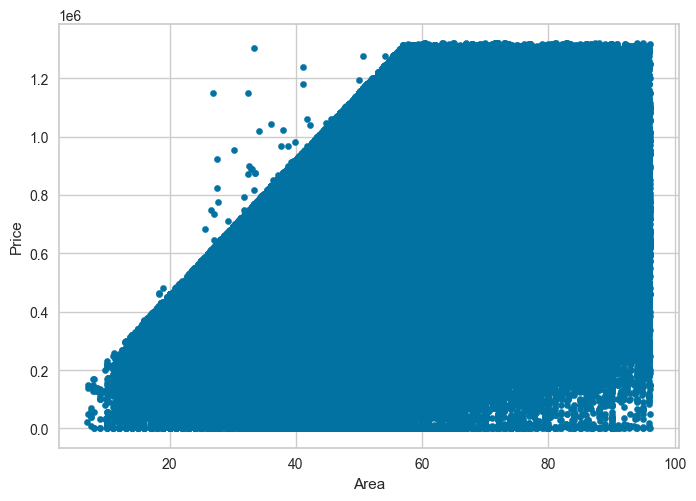

In [38]:
df_price2.plot.scatter(x='Area', y='Price');

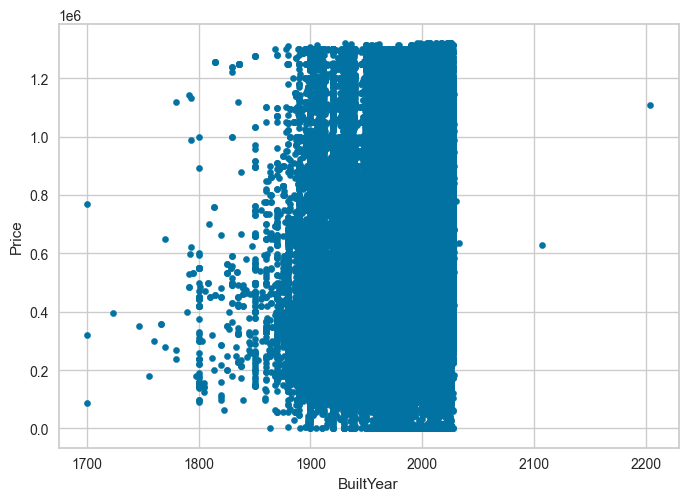

In [39]:
df_price2.plot.scatter(x='BuiltYear', y='Price');

Text(0.5, 1.0, 'Correlation Matrix of Price')

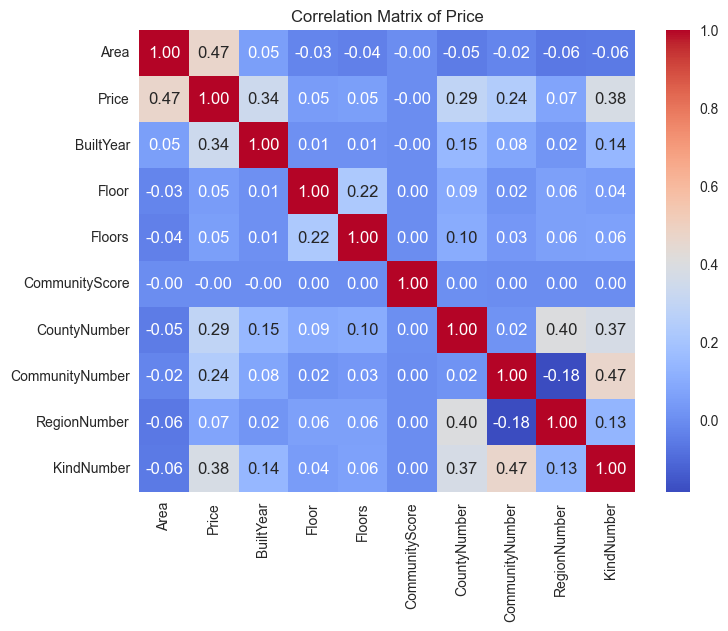

In [40]:
correlation_matrix = df_price2[['Area', 'Price', 'BuiltYear', 'Floor', 'Floors', 'CommunityScore', 'CountyNumber', 'CommunityNumber',
                               'RegionNumber','KindNumber']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Price')

In [41]:
sale_ids = df_price2['SaleId'].reset_index(drop=True)

In [42]:
train_df = df_price2.sample(frac=0.9, random_state=42)
holdout_df = df_price2.drop(train_df.index)

In [43]:
df_price2['VoivodeshipNumber'] = df_price2['VoivodeshipNumber'].astype(str)
df_price2['CountyNumber'] = df_price2['CountyNumber'].astype(str)
df_price2['CommunityNumber'] = df_price2['CommunityNumber'].astype(str)
df_price2['KindNumber'] = df_price2['KindNumber'].astype(str)
df_price2['RegionNumber'] = df_price2['RegionNumber'].astype(str)
if 'StreetNumber' in df_price2.columns:
    df_price2['StreetNumber'] = df_price2['StreetNumber'].astype(str)

In [ ]:
categorical_features_initial = [
    'BuildingType', 'BuildingCondition', 'TypeOfMarket', 'OwnerType', 'Type', 'OfferFrom',
    'VoivodeshipNumber', 'CountyNumber', 'CommunityNumber', 'KindNumber',
    'RegionNumber',
    'Location' # Dodajemy Location do kategorycznych
]
numeric_features_initial = [
    'Area', 'NumberOfRooms', 'Floor', 'Floors', 'CommunityScore'
]
date_features_initial = ['BuiltYear']

# Filtruj cechy, które faktycznie istnieją w df_price3
categorical_features_to_use = [col for col in categorical_features_initial if col in df_price2.columns]
numeric_features_to_use = [col for col in numeric_features_initial if col in df_price2.columns]
date_features_to_use = [col for col in date_features_initial if col in df_price2.columns]

# Definicja cech ignorowanych
ignore_features_list = [
    'SaleId', 'OriginalId', 'PortalId', 'Title', 'Description',
    'OfferPrice', 'RealPriceAfterRenovation', 'OriginalPrice',
    'PricePerSquareMeter', 'DateAddedToDatabase', 'DateAdded',
    'DateLastModification', 'DateLastRaises', 'NewestDate',
    'AvailableFrom', 'Link', 'Phone', 'MainImage', 'OtherImages',
    'NumberOfDuplicates', 'NumberOfRaises', 'NumberOfModifications',
    'IsDuplicatePriceLower', 'IsDuplicatePrivateOwner', 'Score', 'ScorePrecision',
    'NumberOfCommunityComments', 'NumberOfCommunityOpinions', 'Archive',
    'SubRegionNumber', 'EncryptedId',
    'StreetNumber' # Ignorujemy, bo może mieć zbyt wiele unikalnych wartości
]
# Filtruj ignorowane cechy, aby upewnić się, że są w DataFrame
ignore_features_list = [col for col in ignore_features_list if col in df_price2.columns]

transformed_exp = setup(
    data=df_price2,
    target='Price',
    verbose=True, # Ustaw na True dla debugowania setup
    session_id=123,
    log_experiment=True,
    experiment_name=MLFLOW_EXPERIMENT_NAME, 
    log_data=True, 
    log_plots=True, 
    categorical_features=categorical_features_to_use,
    numeric_features=numeric_features_to_use,
    date_features=date_features_to_use,
    # text_features=['Location'], # Usunięte na razie, przeniesione do categorical
    ignore_features=ignore_features_list,
    ordinal_features={'BuildingType': ['Pozostałe', 'Blok', 'Apartamentowiec', 'Kamienica'],
                      'BuildingCondition': ['For_Renovation', 'Good', 'After_Renovation', 'Developer_State']},
    # Dla starszych wersji PyCaret, obsługa wysokiej kardynalności jest często domyślna    # lub można spróbować:
    # high_cardinality_method = 'frequency' # jeśli 'Location' ma dużo kategorii
    # lub zostawić domyślne zachowanie PyCaret dla cech kategorycznych
)
best_transformed_model = transformed_exp.compare_models()
transformed_metrics_df = pull()

,Description,Value
0,Session id,123
1,Target,Price
2,Target type,Regression
3,Original data shape,"(968696, 51)"
4,Transformed data shape,"(968696, 63)"
5,Transformed train set shape,"(678087, 63)"
6,Transformed test set shape,"(290609, 63)"
7,Ignore features,32
8,Ordinal features,2
9,Numeric features,5


2025/05/22 11:39:01 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:39:13
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Ridge Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,90306.6090,15667325341.3267,125167.7285,0.7317,0.4528,38.3658,2.3800
lasso,Lasso Regression,90306.2722,15667413176.7649,125168.0779,0.7317,0.4528,38.3647,12.7690


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:
transformed_exp.X_train_transformed.info()

In [ ]:
transformed_exp.X_train_transformed.head()

In [ ]:
from pycaret.regression import get_config
import matplotlib.pyplot as plt
import seaborn as sns

# Wyciągnij dane oryginalne i przetransformowane
df_raw = df_price2.copy()
df_transformed = get_config("X_train").copy()
df_transformed["Price"] = get_config("y_train")

# Rysowanie wykresów
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(df_raw["Price"], ax=axes[0])
axes[0].set_title("Raw Data")

sns.histplot(df_transformed["Price"], ax=axes[1])
axes[1].set_title("Transformed Data")

plt.tight_layout()
plt.show()

In [ ]:
transformed_exp.dataset.head()

In [ ]:
transformed_exp.dataset_transformed.head()

In [ ]:
df_transformed.plot.scatter(x='Area', y='Price');

In [ ]:
df_transformed.plot.scatter(x='BuiltYear', y='Price');

In [ ]:
plt.figure(figsize=(12, 6))
plt.barh(transformed_metrics_df['Model'], transformed_metrics_df['R2'], color='skyblue')
plt.xlabel('R2')
plt.title('Porównanie dokładności modeli')
plt.gca().invert_yaxis()  # najlepszy model na górze
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
transformed_exp.plot_model(best_transformed_model, plot='error')

In [ ]:
transformed_exp.plot_model(best_transformed_model, plot='feature')

In [ ]:
tuned_model = transformed_exp.tune_model(best_transformed_model, n_iter=3, optimize='R2',choose_better=True)

In [ ]:
#RF nie posiada parametru tuned_model - pominąć w przypadku rf
#tuned_best_models = [best_transformed_model.tune_model(m, optimize='R2') for m in tuned_model]

In [ ]:
# pominąć dla rf
#best_model = transformed_exp.compare_models([tuned_best_models, tuned_model],choose_better=True)

In [ ]:
best_model = transformed_exp.compare_models(tuned_model, sort='R2')

In [ ]:
transformed_exp.predict_model(best_model)

In [ ]:
transformed_exp.plot_model(best_model, plot='error')

In [ ]:
transformed_exp.plot_model(best_model, plot='feature')

In [ ]:
transformed_exp.predict_model(best_model).head(10)

In [ ]:
transformed_exp.plot_model(best_model, plot='error')

In [ ]:
transformed_exp.plot_model(best_model, plot='feature')

In [ ]:
best_final_model = transformed_exp.finalize_model(best_model, experiment_custom_tags={"step": "final"})
best_final_model

In [ ]:
transformed_exp.save_model(best_final_model, '0_full-basic-model')

In [ ]:
transformed_exp.predict_model(best_final_model, data=holdout_df)
predict_holdout_df = transformed_exp.pull()

In [ ]:
mlflow_exp = mlflow.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
runs_df = mlflow.search_runs([mlflow_exp.experiment_id], order_by=["start_time DESC"])
run_id = runs_df['run_id'].values[0]
metrics = predict_holdout_df.drop(columns=["Model"]).to_dict(orient='records')[0]

with mlflow.start_run(run_id=run_id, nested=True):
    for key, value in metrics.items():
        mlflow.log_metric(key, value)

In [ ]:
#predictions = transformed_exp.predict_model(best_final_model)
holdout_predictions = transformed_exp.predict_model(best_final_model) # Zapisz wynik predykcji
display(holdout_predictions.head()) # Wyświetl kilka pierwszych predykcji

In [ ]:
#predicted_column = predict_holdout_df['prediction_label']
#print(predicted_column)
holdout_metrics_df = transformed_exp.pull() # Teraz pobierz metryki z tej predykcji
display(holdout_metrics_df)
predicted_column = holdout_predictions['prediction_label'] # Jeśli chcesz samą kolumnę predykcji
print(predicted_column)

In [ ]:
print(holdout_predictions[['prediction_label']].applymap('{:,.0f}'.format))

In [ ]:
df_last=holdout_predictions[['prediction_label','Price', ]].applymap('{:,.0f}'.format)


In [ ]:
df_last.to_csv('0_new_prices.csv')

In [ ]:
print(df_last.columns)

In [ ]:
print(df_last.head())

In [ ]:
df_last = df_last.reset_index()  
print(df_last.columns)  

In [ ]:
df_last.rename(columns={'index': 'SaleId'}, inplace=True)

In [ ]:
saleflats_df = pd.read_csv('sale_2024_0.csv')

In [ ]:
new_prices_df = pd.read_csv('0_new_prices.csv')

In [ ]:
print("saleflats_df.columns:", saleflats_df.columns.tolist())

In [ ]:
print("new_prices_df.columns:", new_prices_df.columns.tolist())

In [ ]:
new_prices_df = new_prices_df.rename(columns={'Unnamed: 0': 'SaleId', 'Price': 'NewPrice'})

In [ ]:
print("new_prices_df.columns:", new_prices_df.columns.tolist())

In [ ]:
print(new_prices_df.columns)

In [ ]:
print(saleflats_df.columns)

In [ ]:
merged_df = pd.merge(
    saleflats_df,
    new_prices_df[['SaleId', 'NewPrice']],
    left_on='SaleId',  # Kolumna w saleflats_df
    right_on='SaleId',  # Kolumna w new_prices_df
    how='left'
)

In [ ]:
merged_df

In [ ]:
# Krok 2: usuwanie dodatkowej kolumny klucza (opcjonalnie, bo mamy już 'SaleId')
#merged_df.drop(columns=['SaleID'], inplace=True)

# Krok 3: przestawienie kolumny 'NewPrice' obok 'Price'
cols = merged_df.columns.tolist()

# znajdź indeks kolumny 'Price'
price_index = cols.index('Price')

# usuń NewPrice z listy i dodaj ją zaraz po Price
cols.remove('NewPrice')
cols.insert(price_index + 1, 'NewPrice')

# ustaw nową kolejność kolumn
merged_df = merged_df[cols]

In [ ]:
merged_df

In [ ]:
merged_df[merged_df.duplicated()]

In [ ]:
prediction_df = merged_df.copy()

In [ ]:
from pycaret.regression import predict_model

In [ ]:
prediction_df['BuiltYear'] = pd.to_datetime(prediction_df['BuiltYear'], format='%Y', errors='coerce')

In [ ]:
prediction_df_clean = prediction_df.drop(columns=['Price'], errors='ignore')
predictions = predict_model(best_final_model, data=prediction_df_clean)

In [ ]:
predictions['RealPrice'] = prediction_df['Price']

In [ ]:
merged_df['PredictedPrice'] = predictions['prediction_label']

In [ ]:
predictions=predictions[['prediction_label',]].applymap('{:,.0f}'.format)

In [ ]:
# Przenieś kolumnę 'PredictedPrice' za 'NewPrice'
cols = list(merged_df.columns)
new_price_index = cols.index('NewPrice')
# Usuń z listy kolumn
cols.remove('PredictedPrice')
# Dodaj w odpowiednie miejsce
cols.insert(new_price_index + 1, 'PredictedPrice')
# Przekształć DataFrame
merged_df = merged_df[cols]

In [ ]:
merged_df.to_csv('0_new_prices_full.csv')

In [ ]:
merged_df = pd.read_csv('0_new_prices_full.csv')

In [ ]:
merged_df

In [ ]:
merged_df2=merged_df[['PredictedPrice',]].applymap('{:,.0f}'.format)

In [ ]:
merged_df2

In [ ]:
merged_df['PredictedPrice'] = merged_df2['PredictedPrice']

In [ ]:
merged_df.drop(columns=['NewPrice'], inplace=True)

In [ ]:
merged_df

In [ ]:
merged_df.to_csv('full_uzup_mieszkania_ceny.csv')

In [ ]:
# df_p = pd.read_csv('sale_2024_6.csv')

# 1. Kopia oryginalnej dużej tabeli
df = df_p.copy()

# 2. Dopinamy kolumnę z predykcjami po SaleId
if 'NewPrices' in merged_df.columns:
    df = df.merge(merged_df[['SaleId', 'NewPrices']], on='SaleId', how='left')
elif 'PredictedPrice' in merged_df.columns:
    df = df.merge(merged_df[['SaleId', 'PredictedPrice']].rename(columns={'PredictedPrice': 'NewPrices'}), on='SaleId', how='left')
else:
    raise ValueError("W merged_df nie znaleziono kolumny 'NewPrices' ani 'PredictedPrice'")

# 3. Tam, gdzie jest dostępna cena ('Price'), kopiujemy ją do 'NewPrices'
df.loc[df['Price'].notna(), 'NewPrices'] = df.loc[df['Price'].notna(), 'Price']

# 4. Przenosimy kolumnę 'NewPrices' za 'Price'
cols = df.columns.tolist()
if 'NewPrices' in cols:
    cols.remove('NewPrices')
    price_idx = cols.index('Price')
    cols.insert(price_idx + 1, 'NewPrices')
    df = df[cols]

# 5. Załaduj model z PyCaret
model = load_model('6_best_price_modelLGBM')

# 6. Przygotuj dane bez kolumny 'Price', by uniknąć błędu z NaN
df_for_prediction = df.drop(columns=['Price'], errors='ignore')

# 7. Przeprowadź predykcję
predicted_df = predict_model(model, data=df_for_prediction)

# 8. Powiąż wynik predykcji po SaleID
df = df.merge(predicted_df[['SaleID', 'prediction_label']], on='SaleID', how='left', suffixes=('', '_new'))

# 9. Nadpisz kolumnę 'NewPrices' nowymi przewidywaniami
df['NewPrices'] = df['prediction_label']

# 10. Przenosimy kolumnę 'NewPrices' za 'Price' (jeszcze raz)
cols = df.columns.tolist()
if 'NewPrices' in cols:
    cols.remove('NewPrices')
    price_idx = cols.index('Price')
    cols.insert(price_idx + 1, 'NewPrices')
    df = df[cols]

# 11. Zaktualizuj saleflats_b
saleflats_b = df

df2=df[['NewPrices',]].applymap('{:,.0f}'.format)

# Nadpisanie kolumny 'NewPrices' w df sformatowaną wersją
df['NewPrices'] = df2['NewPrices']

df

df.to_csv('6_new_prices_FULL2.csv')

df.sample(100)